## Impressions and Reviews  
- Elasticnet CV -> Elasticnet fit을 통해 최적의 alpha와 l1_ratio를 찾을 수 있다
- ElasticnetCV 를 통해 알아낸 l1 또는 l2 혹은 mix를 사용해서 feature selection을 수행할 수 있다 (다중공선성이 있을 때는 Ridge가 Lasso보다 낫기도 하다)

- ### **Dataset에 의한 과적합을 방지하기 위해 feature selection을 하는 것이 바람직해보이고 이에 Elasticnet 사용 (Ridge + Lasso)**

- ### **l1_ratio 가 1이면 Lasso, 0이면 Ridge, 0과1사이면 Mix**
- ### **alpha 는 regularization amount 의미**

- ###  **l2 비중을 높일 때 덜중요한 변수의 계수는 0에 가까워지고, feature selection의 technique으로 사용 가능**
- ### **다중공선성 존재할 때도 Ridge가 lasso보다 나은 성능을 보인다**


Hello there everyone!

I am new to this competition but it looks like this dataset leads to overfitting problems. In addition, it seems like Mercedes is interested in reducing the dataset to a few meaningful variables. Therefore, I thought it was a good idea to try one of the best linear models I know for tackling overfitting that works also as a feature selection method: **Elastic Nets**.  

Elastic Nets are essentially a **Lasso/Ridge** hybrid, that entails the minimization of an objective function that includes both **L1** (Lasso) and **L2** (Ridge) norms. You can find more about ElasticNets [here][1].  

For the sake of this notebook it is important to notice that Elastic nets depends on two parameters: 

* the **l1_ratio**, i.e. the tradeoff between the two norms (l1_ratio = 0 --> Ridge,  l1_ratio = 1 --> Lasso, 0<l1_ration<1 --> Mix of the two);
* **alpha**, that regulates the amount of penalty applied.

It is important to know that minimizing the L1 norm will force some coefficients to shrink to zero, and that's why Elastic Nets can be used as feature selection techniques. Besides, when there's a high degree of collinearity in the data, the cross-validation procedure used to determine these two parameters will return low l1_ratio since Ridge tends to outperform Lasso in these cases.

Ok... let's use scikit-learn and see how these methods perfom and which features they select!

  [1]: http://www.onthelambda.com/2015/08/19/kickin-it-with-elastic-net-regression/

# Initialization

In [2]:
# load modules
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# load data
train_df  = pd.read_csv('/content/train.csv')
test_df  = pd.read_csv('/content/test.csv')

In [10]:
print(train_df.shape)
train_df.head()

(4209, 377)


,ID,X0,X1,X2,X3,X4,X5,X6,X8,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,...,X345,X346,X347,X348,X349,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359,X360,X361,X362,X363,X364,X365,X366,X367,X368,X369,X370,X371,X372,X373,X374,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,k,v,at,a,d,u,j,o,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,6,k,t,av,e,d,y,l,o,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,7,az,w,n,c,d,x,j,x,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,9,az,t,n,f,d,x,l,e,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,13,az,v,n,f,d,h,d,n,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
# X, y 분리 후 dataset 통합
train_y = train_df['y']
train_df.drop('y', axis = 1, inplace = True)
test_ids = test_df.ID.values
all_df = pd.concat([train_df,test_df], axis = 0)

# 명목형 ohe 수행
categorical =  ["X0", "X1", "X2", "X3", "X4", "X5", "X6", "X8"]
for f in categorical:
    dummies = pd.get_dummies(all_df[f], prefix = f, prefix_sep = '_')
    all_df = pd.concat([all_df, dummies], axis = 1)

# ordinal 명목형 변수 drop
all_df.drop(categorical, axis = 1, inplace = True)

In [7]:
# 'id' drop 후 train test 분리
train_X = all_df.drop(["ID"], axis=1).iloc[:len(train_df),:]
test_X = all_df.drop(["ID"], axis=1).iloc[len(train_df):,:]

In [8]:
print(train_X.head())
print(test_X.head())

   X10  X11  X12  X13  X14  X15  X16  ...  X8_s  X8_t  X8_u  X8_v  X8_w  X8_x  X8_y
0    0    0    0    1    0    0    0  ...     0     0     0     0     0     0     0
1    0    0    0    0    0    0    0  ...     0     0     0     0     0     0     0
2    0    0    0    0    0    0    0  ...     0     0     0     0     0     1     0
3    0    0    0    0    0    0    0  ...     0     0     0     0     0     0     0
4    0    0    0    0    0    0    0  ...     0     0     0     0     0     0     0

[5 rows x 579 columns]
   X10  X11  X12  X13  X14  X15  X16  ...  X8_s  X8_t  X8_u  X8_v  X8_w  X8_x  X8_y
0    0    0    0    0    0    0    0  ...     0     0     0     0     1     0     0
1    0    0    0    0    0    0    0  ...     0     0     0     0     0     0     1
2    0    0    0    0    1    0    0  ...     0     0     0     0     0     0     0
3    0    0    0    0    0    0    0  ...     0     0     0     0     0     0     0
4    0    0    0    0    1    0    0  ...     0     

# Model development and testing

In [ ]:
# alpha와 l1_ratio 최적 조합을 cv를 통해 찾는다
# ElasticnetCV모델을 Elasticnet Regression모델 안에 넣고 fit
from sklearn.linear_model import ElasticNetCV, ElasticNet

cv_model = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, .995, 1], eps=0.001, n_alphas=100, fit_intercept=True, 
                        normalize=True, precompute='auto', max_iter=2000, tol=0.0001, cv=5, 
                        copy_X=True, verbose=0, n_jobs=-1, positive=False, random_state=None, selection='cyclic')

In [ ]:
cv_model.fit(train_X, train_y)

ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
       l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 0.995, 1], max_iter=2000,
       n_alphas=100, n_jobs=-1, normalize=True, positive=False,
       precompute='auto', random_state=None, selection='cyclic',
       tol=0.0001, verbose=0)

In [ ]:
# 최적의 l1_ratio는 1로 Lasso를 
print('Optimal alpha: %.8f'%cv_model.alpha_)
print('Optimal l1_ratio: %.3f'%cv_model.l1_ratio_)
print('Number of iterations %d'%cv_model.n_iter_)

Optimal alpha: 0.00314540
Optimal l1_ratio: 1.000
Number of iterations 603


**l1_ratio = 1**, that means we are just using Lasso.

In [ ]:
# l1_ratio 가 1.0 이 최적이므로  Lasso 사용
# train model with best parameters from CV
model = ElasticNet(l1_ratio=cv_model.l1_ratio_, alpha = cv_model.alpha_, max_iter=cv_model.n_iter_, fit_intercept=True, normalize = True)
model.fit(train_X, train_y)

ElasticNet(alpha=0.0031453993038814206, copy_X=True, fit_intercept=True,
      l1_ratio=1.0, max_iter=603, normalize=True, positive=False,
      precompute=False, random_state=None, selection='cyclic', tol=0.0001,
      warm_start=False)

In [ ]:
# r2 score on training dataset
print(r2_score(train_y, model.predict(train_X)))

0.586978770942


Uncomment below if you want the predictions on the test dataset (LB 0.547+)

In [ ]:
# preds = model.predict(test_X)
# df_sub = pd.DataFrame({'ID': test_ids, 'y': preds})
# df_sub.to_csv('elnet_submission_dummies.csv', index=False)

# Feature importance
Let's see the importance of each feature based on the absolute value of their coefficients 

68 features, reduction of 88.26%


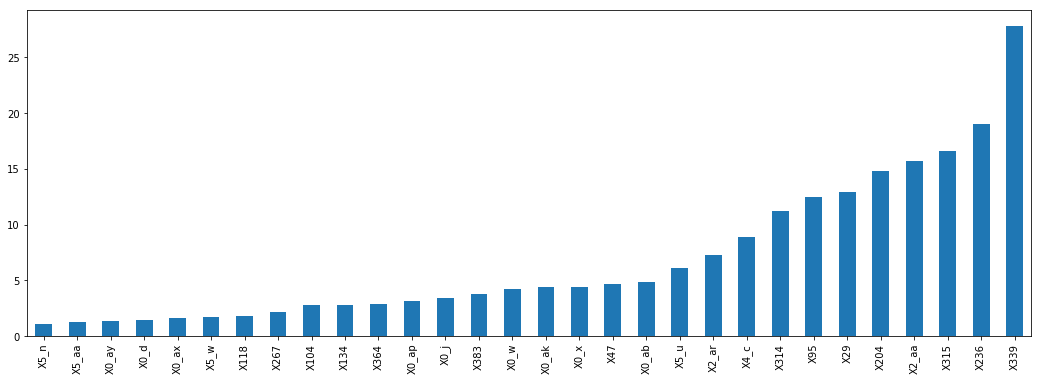

In [ ]:
# model의 coef_를 통해 feature importance 확인
feature_importance = pd.Series(index = train_X.columns, data = np.abs(model.coef_))

n_selected_features = (feature_importance>0).sum()
print('{0:d} features, reduction of {1:2.2f}%'.format(
    n_selected_features,(1-n_selected_features/len(feature_importance))*100)) # 0이상의 coef가진 변수만 추출 (88%감소 -> 68개)

feature_importance.sort_values().tail(30).plot(kind = 'bar', figsize = (18,6))

## It's nice to see how these features compares with those selected by xgboost or other nonlinear methods. Anyway, 88.26% features reduction (with respect to dataset with dummies) looks nice. Besides, the performance on the LB of this linear method seems to be close to those of more sophisticated ones. 

Vote this notebook if you liked it :P

Cheers